В этом ноутбуке были протестированы три метода генерации эмбеддингов (PCA, non-negative ALS, autoencoder) для генерации профилей пользователей из датасета Netflix меньшей размерности. Напомним, что исходная размерность профиля 302. Кроме того, применимость методов генерации эмбеддингов была исследована с точки зрения качества моделей генерации синтетических данных и с точки зрения качества компоненты функции отклика, отвечающей за приближение отклика из исторических данных.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import itertools

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score

import pyspark.sql.functions as sf
import pyspark.sql.types as st
import pyspark.ml.functions as smf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.sql.window import Window

from replay.session_handler import State

from sim4rec.utils import pandas_to_spark
from sim4rec.response import ParametricResponseFunction, BernoulliResponse
from sim4rec.utils import VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic
from sim4rec.modules import EncoderEstimator

from datautils import *

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

SPARK_LOCAL_DIR = './tmp'
DATA_PATH = r'file:///data/home/estavinova/DL_0/real_data_simulator/Netflix'

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/17 13:09:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/17 13:09:56 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/17 13:09:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/17 13:09:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/17 13:09:58 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/11/17 13:09:58 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


# Read data

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Netflix): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [2]:
USER_GENERATOR_FRAC = 0.028 # 10k users

users_df_train = spark.read.csv(f'{DATA_PATH}/train/users.csv', header=True, schema=NETFLIX_USER_SCHEMA)
items_df_train = spark.read.csv(f'{DATA_PATH}/train/items.csv', header=True, schema=NETFLIX_ITEM_SCHEMA)
log_df_train   = spark.read.csv(f'{DATA_PATH}/train/rating.csv', header=True, schema=NETFLIX_LOG_SCHEMA)

log_df_train = log_df_train.join(users_df_train, log_df_train['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_idx'] == items_df_train['item_idx'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

ITEMS_FEATURES = items_df_train.columns[1:2] + items_df_train.columns[4:]

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.sample(0.197).cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/17 13:10:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10032322

In [3]:
users_df_val = spark.read.csv(f'{DATA_PATH}/val/users.csv', header=True, schema=NETFLIX_USER_SCHEMA)
items_df_val = spark.read.csv(f'{DATA_PATH}/val/items.csv', header=True, schema=NETFLIX_ITEM_SCHEMA)
log_df_val   = spark.read.csv(f'{DATA_PATH}/val/rating.csv', header=True, schema=NETFLIX_LOG_SCHEMA)

log_df_val = log_df_val.join(users_df_val, log_df_val['user_idx'] == users_df_val['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_idx'] == items_df_val['item_idx'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.sample(0.2047).cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

4998642

In [4]:
users_df_test = spark.read.csv(f'{DATA_PATH}/test/users.csv', header=True, schema=NETFLIX_USER_SCHEMA)
items_df_test = spark.read.csv(f'{DATA_PATH}/test/items.csv', header=True, schema=NETFLIX_ITEM_SCHEMA)
log_df_test   = spark.read.csv(f'{DATA_PATH}/test/rating.csv', header=True, schema=NETFLIX_LOG_SCHEMA)

log_df_test = log_df_test.join(users_df_test, log_df_test['user_idx'] == users_df_test['user_idx'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_idx'] == items_df_test['item_idx'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.sample(0.2).cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5024095

In [5]:
def test_model(model_class, train_data, test_data, assembler, extractor, bernoulli):
    model = model_class(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec')

    start = time.time()
    pipeline = Pipeline(stages=[assembler, model, extractor, bernoulli]).fit(train_data)
    print(f'Fitting of pipeline with {type(model).__name__}: {time.time() - start}')

    pred_pdf = pipeline.transform(test_data).select("relevance", "__prob").toPandas()
    roc_auc = roc_auc_score(pred_pdf.relevance, pred_pdf.__prob)
    print(f'Regression ROC AUC: {roc_auc}')

    return {'Model' : type(model).__name__, 'ROC-AUC' : roc_auc}

def test_generator(train_data, generator_name, fancy_generator_name, embeddings_name):
    user_generator = SDVDataGenerator(
        label='synth',
        id_column_name='user_idx',
        model_name=generator_name,
        parallelization_level=8,
        seed=1234
    )

    start = time.time()
    user_generator.fit(train_data.drop('user_idx').sample(USER_GENERATOR_FRAC))
    print(f'Fitting of {generator_name} on {embeddings_name} embeddings: {time.time() - start}')

    real_users = train_data.sample(USER_GENERATOR_FRAC)
    syn_users = user_generator.generate(real_users.count())
    gen_score = evaluate_synthetic(syn_users.drop('user_idx'), real_users.drop('user_idx'))
    print(gen_score)

    gen_result = pd.DataFrame(index = np.arange(4))
    gen_result['Model_name'] = fancy_generator_name
    gen_result['Metric_score'] = [v for k, v in gen_score.items()]
    gen_result['Metric_name'] = [k for k, v in gen_score.items()]

    return gen_result

def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values

# Initial quality of response function Real component

Сначала оценим качество компоненты Real, отвечающей за приближение отклика в исторических данных, на исходных профилях польззователей и предложений.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [6]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:-1] + ITEMS_FEATURES,
    outputCol='features'
)

vee = VectorElementExtractor(inputCol='__prob_vec', outputCol='__prob', index=1)
br = BernoulliResponse (inputCol='__prob', outputCol='response', seed=1234)

train_df = log_df_val\
    .join(users_df_train, 'user_idx', 'left')\
    .join(items_df_train, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .join(users_df_val, 'user_idx', 'left')\
    .join(items_df_val, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

In [7]:
full_feature_metrics = []

# Logistic regression

In [8]:
full_feature_metrics.append(
    test_model(
        model_class=LogisticRegression,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

22/11/17 13:20:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/17 13:20:15 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Fitting of pipeline with LogisticRegression: 420.9364013671875


Regression ROC AUC: 0.7208425342578532


# Random forest

In [15]:
full_feature_metrics.append(
    test_model(
        model_class=RandomForestClassifier,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with RandomForestClassifier: 160.53016710281372


Regression ROC AUC: 0.559561956373764


In [16]:
train_df.unpersist()
test_df.unpersist()

pd.DataFrame(full_feature_metrics)

,Model,ROC-AUC
0,LogisticRegression,0.720843
1,RandomForestClassifier,0.559562


# PCA

In [9]:
pca_va = VectorAssembler(
    inputCols=users_df_train.columns[1:-1],
    outputCol='features'
)

start = time.time()
pca = PCA(k=9, inputCol='features', outputCol='pca_features').fit(pca_va.transform(users_df_train))
print(f'PCA fit time: {time.time() - start}')

pca.explainedVariance

22/11/17 13:36:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/17 13:36:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


PCA fit time: 11.431146383285522


DenseVector([0.3486, 0.0279, 0.0214, 0.0185, 0.0157, 0.0143, 0.0136, 0.0122, 0.0117])

In [11]:
pca_users_train = pca.transform(pca_va.transform(users_df_train)).select('user_idx', 'pca_features')

pca_users_train = pca_users_train\
    .withColumn('user_feature', smf.vector_to_array('pca_features'))\
    .select(['user_idx'] + [sf.col('user_feature')[i] for i in range(9)])\
    .cache()

pca_users_train.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,0,-3.595783,0.316566,0.214321,0.193317,-0.029960,-0.076129,0.294963,-0.024910,0.208980
1,1,-4.025625,0.289827,0.173262,0.174404,0.001099,-0.131625,0.297719,-0.013480,0.212237
2,3,-3.384291,0.342881,0.271273,0.212901,0.000769,-0.104027,0.291688,-0.066392,0.217279
3,4,-3.003308,0.205835,0.249211,0.480577,0.211469,-0.177333,0.551470,0.261086,0.099394
4,5,-3.799361,0.102418,0.130506,0.077469,0.067097,-0.189672,0.277142,-0.073044,0.112268
...,...,...,...,...,...,...,...,...,...,...
365787,480182,-3.312829,0.293105,0.218792,0.196616,0.093704,-0.102092,0.312283,-0.051719,0.231047
365788,480183,-4.007493,0.609736,0.930526,0.354990,-1.246593,-0.781468,0.707859,0.208256,-1.127146
365789,480185,-3.648306,0.183644,0.190015,0.190791,-0.067906,-0.165746,0.412720,-0.016262,0.188441
365790,480187,-3.867481,0.286790,0.257627,0.175143,0.028162,-0.155398,0.323344,-0.027551,0.222202


In [12]:
pca_users_val = pca.transform(pca_va.transform(users_df_val)).select('user_idx', 'pca_features')

pca_users_val = pca_users_val\
    .withColumn('user_feature', smf.vector_to_array('pca_features'))\
    .select(['user_idx'] + [sf.col('user_feature')[i] for i in range(9)])\
    .cache()

pca_users_val.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,0,-3.500338,0.330837,0.224767,0.201715,-0.024323,-0.085068,0.307592,-0.030815,0.205077
1,1,-4.063943,0.305376,0.174499,0.181510,-0.010718,-0.131645,0.288134,-0.011218,0.214673
2,3,-3.383029,0.336954,0.256217,0.214335,-0.009671,-0.118181,0.291216,-0.064696,0.216930
3,4,-4.158492,0.127731,0.128297,0.669201,0.093987,-0.130010,0.248748,0.085271,0.148341
4,5,-3.799361,0.102418,0.130506,0.077469,0.067097,-0.189672,0.277142,-0.073044,0.112268
...,...,...,...,...,...,...,...,...,...,...
460684,480184,-4.019537,0.301630,0.309988,0.176899,-0.037969,-0.091258,0.317922,0.022903,0.224169
460685,480185,-3.690053,0.259013,0.169464,0.156307,-0.012174,-0.111663,0.325537,0.001159,0.183525
460686,480186,-4.335519,0.184928,0.301842,0.379964,0.332384,-0.160480,0.461215,0.012197,0.253595
460687,480187,-4.021257,0.288347,0.260043,0.176684,-0.001241,-0.140576,0.298059,-0.031117,0.212905


# Generators quality with PCA

In [18]:
gen_result_pca = pd.DataFrame()

# GaussianCopula

In [19]:
gen_result_pca = pd.concat([
    gen_result_pca,
    test_generator(
        train_data=pca_users_train,
        generator_name='gaussiancopula',
        fancy_generator_name='GaussianCopula',
        embeddings_name='PCA'
    )
])

Fitting of gaussiancopula on PCA embeddings: 0.7895703315734863


{'LogisticDetection': 0.5744626971206923, 'SVCDetection': 0.04465681510766906, 'KSTest': 0.818615359315902, 'ContinuousKLDivergence': 0.8478001549689618}


# CTGAN

In [20]:
gen_result_pca = pd.concat([
    gen_result_pca,
    test_generator(
        train_data=pca_users_train,
        generator_name='ctgan',
        fancy_generator_name='CTGAN',
        embeddings_name='PCA'
    )
])

Fitting of ctgan on PCA embeddings: 6858.941332101822


{'LogisticDetection': 0.6853701417509372, 'SVCDetection': 0.3308623136535588, 'KSTest': 0.8755247151546304, 'ContinuousKLDivergence': 0.910540305474519}


# CopulaGAN

In [21]:
gen_result_pca = pd.concat([
    gen_result_pca,
    test_generator(
        train_data=pca_users_train,
        generator_name='copulagan',
        fancy_generator_name='CopulaGAN',
        embeddings_name='PCA'
    )
])

Fitting of copulagan on PCA embeddings: 6239.525605678558


{'LogisticDetection': 0.6431148029579887, 'SVCDetection': 0.3244245279020781, 'KSTest': 0.8793625880147363, 'ContinuousKLDivergence': 0.9086657246533293}


# TVAE

In [22]:
gen_result_pca = pd.concat([
    gen_result_pca,
    test_generator(
        train_data=pca_users_train,
        generator_name='tvae',
        fancy_generator_name='TVAE',
        embeddings_name='PCA'
    )
])

Fitting of tvae on PCA embeddings: 1275.8144929409027


{'LogisticDetection': 0.8166819904479097, 'SVCDetection': 0.33561245306319265, 'KSTest': 0.8853547787078068, 'ContinuousKLDivergence': 0.9013387182034384}


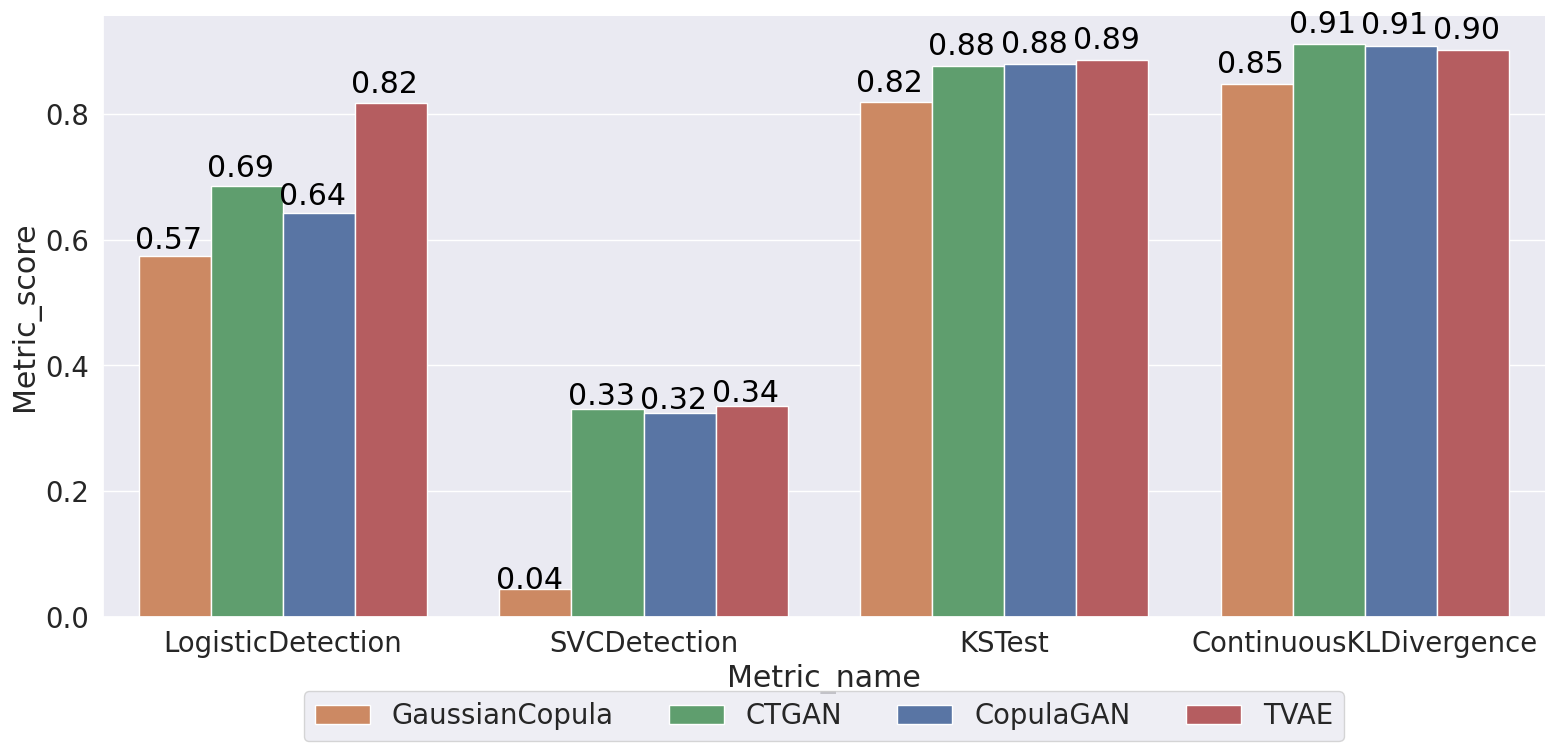

In [23]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_pca, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_pca)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

Видно, что TVAE дает лучшее качество по 3 из 4 метрик.

# Response function Real component quality

Проверим, что использование эмбеддингов не ухудшает качество компоненты Real функции отклика.

In [13]:
va = VectorAssembler(
    inputCols=pca_users_train.columns[1:] + ITEMS_FEATURES,
    outputCol='features'
)

train_df = log_df_val\
    .join(pca_users_train, 'user_idx', 'left')\
    .join(items_df_train, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .join(pca_users_val, 'user_idx', 'left')\
    .join(items_df_val, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

In [14]:
pca_feature_metrics = []

# Logistic Regression

In [17]:
pca_feature_metrics.append(
    test_model(
        model_class=LogisticRegression,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with LogisticRegression: 148.79742813110352


Regression ROC AUC: 0.7189234243998684


# Random forest

In [18]:
pca_feature_metrics.append(
    test_model(
        model_class=RandomForestClassifier,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with RandomForestClassifier: 99.00051712989807


Regression ROC AUC: 0.559561956373764


In [19]:
train_df.unpersist()
test_df.unpersist()

pca_users_train.unpersist()
pca_users_val.unpersist()

pd.DataFrame(pca_feature_metrics)

,Model,ROC-AUC
0,LogisticRegression,0.718923
1,RandomForestClassifier,0.559562


При использовании эмбеддингов PCA качество компоненты Real практически не изменилось, что может быть объяснено разреженностью исходных фич.

# Non-negative ALS

Проделаем те же самые эксперименты с другим методом генерации эмбеддингов.

In [22]:
als_estimator = ALS(rank=15, maxIter=10, seed=0, nonnegative = True)

start = time.time()
als_train = als_estimator.fit(
    log_df_train\
        .withColumnRenamed('user_idx', 'user')\
        .withColumnRenamed('item_idx', 'item')\
        .withColumnRenamed('relevance', 'rating')\
        .select('user', 'item', 'rating')
)
print(f'Fitting of ALS: {time.time() - start}')

Fitting of ALS: 51.20000982284546


In [23]:
als_users_train = als_train.userFactors.orderBy("id")
als_users_train = als_users_train\
    .withColumn('user_feature', sf.col('features'))\
    .select(['id'] + [sf.col('user_feature')[i] for i in range(15)])\
    .withColumnRenamed('id', 'user_idx')\
    .cache()

als_users_train.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8],user_feature[9],user_feature[10],user_feature[11],user_feature[12],user_feature[13],user_feature[14]
0,0,0.232550,0.152288,0.246190,0.266065,0.239335,0.278156,0.187780,0.255782,0.178614,0.224496,0.364796,0.254675,0.245786,0.187105,0.199692
1,1,0.199788,0.170998,0.263381,0.234406,0.244801,0.274344,0.235377,0.248747,0.219592,0.199968,0.329055,0.238464,0.233599,0.211901,0.210964
2,3,0.188168,0.168157,0.256236,0.210415,0.247141,0.259339,0.258854,0.229704,0.226710,0.175887,0.294966,0.217198,0.215464,0.205670,0.200401
3,5,0.273947,0.161387,0.268133,0.317653,0.260229,0.312825,0.178076,0.292506,0.177522,0.267332,0.431079,0.294211,0.283269,0.196728,0.219595
4,6,0.308598,0.161939,0.262925,0.344747,0.252766,0.321940,0.170058,0.292634,0.200682,0.273306,0.429825,0.309626,0.280843,0.204631,0.229492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316439,480182,0.200097,0.129785,0.210823,0.229940,0.203579,0.236918,0.156051,0.219658,0.149755,0.191495,0.315600,0.216704,0.209959,0.157356,0.170107
316440,480183,0.230725,0.161970,0.260489,0.262247,0.252456,0.286026,0.214325,0.262297,0.197109,0.220711,0.365105,0.255117,0.247349,0.199283,0.209544
316441,480185,0.201683,0.189383,0.289457,0.222994,0.276238,0.285132,0.301591,0.252641,0.260448,0.187401,0.318663,0.235634,0.234694,0.231843,0.224073
316442,480187,0.233588,0.170555,0.269629,0.259516,0.277403,0.292691,0.246911,0.262892,0.214821,0.217429,0.360925,0.253709,0.259198,0.211194,0.218394


In [24]:
start = time.time()
als_val = als_estimator.fit(
    log_df_val\
        .withColumnRenamed('user_idx', 'user')\
        .withColumnRenamed('item_idx', 'item')\
        .withColumnRenamed('relevance', 'rating')\
        .select(["user", "item", "rating"])
)
print(f'Fitting of ALS: {time.time() - start}')

Fitting of ALS: 37.75630807876587


In [25]:
als_users_val = als_val.userFactors.orderBy("id")
als_users_val = als_users_val\
    .withColumn('user_feature', sf.col('features'))\
    .select(['id'] + [sf.col('user_feature')[i] for i in range(15)])\
    .withColumnRenamed('id', 'user_idx')\
    .cache()

als_users_val.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8],user_feature[9],user_feature[10],user_feature[11],user_feature[12],user_feature[13],user_feature[14]
0,0,0.226237,0.235622,0.260999,0.319470,0.194825,0.324018,0.210438,0.316089,0.318821,0.176400,0.295383,0.215653,0.224771,0.218575,0.226772
1,1,0.250455,0.280127,0.271094,0.265474,0.230185,0.260251,0.257965,0.253303,0.259886,0.228702,0.241557,0.197926,0.234548,0.252371,0.271342
2,3,0.403181,0.217063,0.333598,0.335841,0.165457,0.271333,0.312029,0.252316,0.257432,0.221066,0.298611,0.248170,0.173710,0.175853,0.207499
3,4,0.268693,0.305017,0.313423,0.244886,0.258977,0.242677,0.259071,0.229137,0.220566,0.267110,0.207121,0.191487,0.254154,0.284349,0.290818
4,6,0.269083,0.069912,0.231029,0.335587,0.101609,0.436879,0.191995,0.383199,0.394817,0.043976,0.336853,0.218101,0.081482,0.113067,0.125371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355499,480184,0.226614,0.227288,0.265619,0.360600,0.187788,0.340729,0.198703,0.376026,0.356928,0.156543,0.330318,0.217969,0.203930,0.205475,0.221704
355500,480185,0.174646,0.197049,0.231336,0.338404,0.299249,0.451879,0.207225,0.386347,0.355197,0.138603,0.316887,0.193586,0.114263,0.168961,0.098902
355501,480186,0.234090,0.267940,0.266711,0.308241,0.204334,0.308433,0.220504,0.321084,0.305272,0.195197,0.292424,0.213843,0.229577,0.228480,0.252296
355502,480187,0.231289,0.227207,0.263796,0.331225,0.186597,0.341595,0.204325,0.328662,0.344473,0.178579,0.339829,0.194740,0.194162,0.182330,0.198063


# Generators quality with ALS

In [46]:
gen_result_als = pd.DataFrame()

# GaussianCopula

In [47]:
gen_result_als = pd.concat([
    gen_result_als,
    test_generator(
        train_data=als_users_train,
        generator_name='gaussiancopula',
        fancy_generator_name='GaussianCopula',
        embeddings_name='NMF'
    )
])

Fitting of gaussiancopula on NMF embeddings: 0.8351452350616455


{'LogisticDetection': 0.834907405215444, 'SVCDetection': 0.3004577710613424, 'KSTest': 0.8962627748236982, 'ContinuousKLDivergence': 0.7689682155353067}


# CTGAN

In [48]:
gen_result_als = pd.concat([
    gen_result_als,
    test_generator(
        train_data=als_users_train,
        generator_name='ctgan',
        fancy_generator_name='CTGAN',
        embeddings_name='NMF'
    )
])

Fitting of ctgan on NMF embeddings: 6989.19064950943


{'LogisticDetection': 0.35573624571075657, 'SVCDetection': 0.052430886975221136, 'KSTest': 0.8929568032146445, 'ContinuousKLDivergence': 0.7937018888735204}


# CopulaGAN

In [49]:
gen_result_als = pd.concat([
    gen_result_als,
    test_generator(
        train_data=als_users_train,
        generator_name='copulagan',
        fancy_generator_name='CopulaGAN',
        embeddings_name='NMF'
    )
])

Fitting of copulagan on NMF embeddings: 6492.808953762054


{'LogisticDetection': 0.46191953381029494, 'SVCDetection': 0.0538849176707229, 'KSTest': 0.8980688876341049, 'ContinuousKLDivergence': 0.8047929774479273}


# TVAE

In [51]:
gen_result_als = pd.concat([
    gen_result_als,
    test_generator(
        train_data=als_users_train,
        generator_name='tvae',
        fancy_generator_name='TVAE',
        embeddings_name='NMF'
    )
])

Fitting of tvae on NMF embeddings: 2807.3672828674316


{'LogisticDetection': 0.7602521793585806, 'SVCDetection': 0.2179614279658887, 'KSTest': 0.9515737243575502, 'ContinuousKLDivergence': 0.9151427038993837}


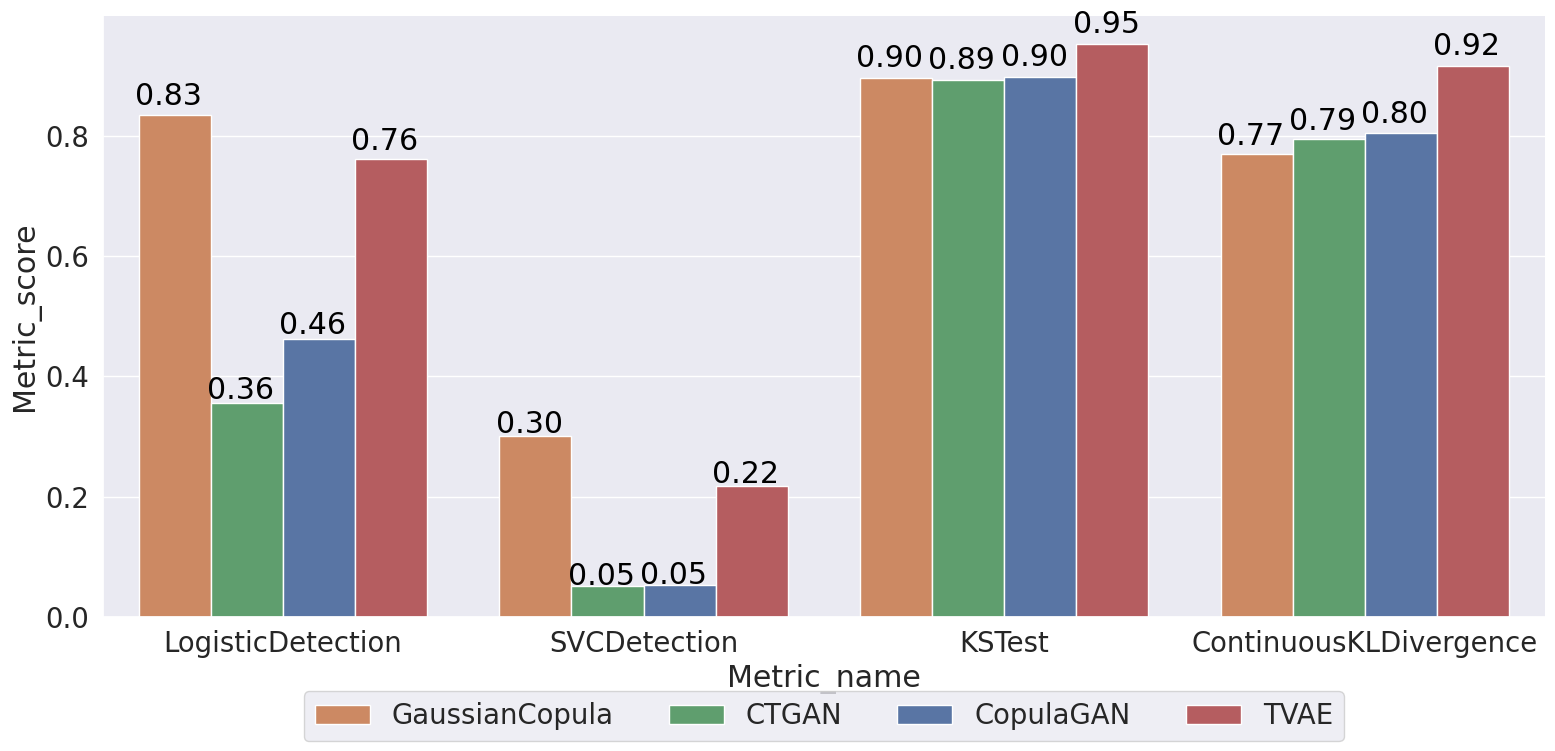

In [52]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_als, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_als)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

In [26]:
va = VectorAssembler(
    inputCols=als_users_train.columns[1:] + ITEMS_FEATURES,
    outputCol='features'
)

train_df = log_df_val\
    .join(als_users_train, 'user_idx', 'left')\
    .join(items_df_train, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .join(als_users_val, 'user_idx', 'left')\
    .join(items_df_val, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

In [27]:
als_feature_metrics = []

# Logistic Regression

In [28]:
als_feature_metrics.append(
    test_model(
        model_class=LogisticRegression,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with LogisticRegression: 161.91922855377197


Regression ROC AUC: 0.6984341574893626


# Random forest

In [29]:
als_feature_metrics.append(
    test_model(
        model_class=RandomForestClassifier,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with RandomForestClassifier: 76.54342770576477


Regression ROC AUC: 0.6203532567756723


In [31]:
train_df.unpersist()
test_df.unpersist()

als_users_train.unpersist()
als_users_val.unpersist()

pd.DataFrame(als_feature_metrics)

,Model,ROC-AUC
0,LogisticRegression,0.698434
1,RandomForestClassifier,0.620353


В случае метода ALS нет явно доминирующей по качеству модели генерации синтетики. Но качество компоненты Real все равно выше, чем в случае исходных профилей, для всех моделей аппроксимации отклика.

# Autoencoder

In [32]:
LATENT_DIM = 15

start = time.time()
encoder = EncoderEstimator(
    inputCols=users_df_train.columns[1:],
    outputCols=[f'emb_{i}' for i in range(LATENT_DIM)],
    hidden_dim=16,
    lr=0.001,
    batch_size=64,
    num_loader_workers=4,
    max_iter=50,
    device_name='cpu'
).fit(users_df_train)
print(f'Fitting of aetoencoder: {time.time() - start}')

Fitting of aetoencoder: 15198.564724683762


In [33]:
enc_users_train = encoder.transform(users_df_train)
enc_users_train = enc_users_train.withColumn('row_index', sf.row_number().over(Window.orderBy(sf.monotonically_increasing_id())))
enc_users_train = enc_users_train\
    .join(
        users_df_train.select('user_idx').withColumn('row_index', sf.row_number().over(Window.orderBy(sf.monotonically_increasing_id()))),
        on=["row_index"]
    )\
    .drop("row_index")\
    .cache()
enc_users_train.toPandas()

22/11/06 15:02:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/06 15:02:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,user_idx
0,-1.956926,1.684702,1.184815,-1.548965,2.081555,-2.922084,2.127467,1.847809,3.896766,0.385026,0.186281,0.613285,0.661424,-2.604004,-0.416313,0
1,-1.846012,1.582472,1.082073,-1.630885,1.965744,-2.953809,2.011763,1.741428,3.923600,0.483600,0.278201,0.522276,0.727750,-2.492884,-0.501757,1
2,-1.731368,1.474834,0.967733,-1.735268,1.848678,-3.018725,1.892974,1.630361,3.985917,0.596253,0.386771,0.417589,0.813915,-2.380846,-0.605072,3
3,17.531099,-18.162672,-21.630281,-30.273090,-16.954407,-30.289715,-17.639231,-17.802946,33.115829,26.721695,26.146189,-22.602119,24.980513,14.578947,-25.722906,4
4,4.182262,-4.312871,-5.388802,-8.592231,-4.067668,-8.673961,-4.168255,-4.215481,9.799827,7.348484,7.003366,-5.738051,6.628592,3.158096,-6.989782,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365787,-1.911965,1.642888,1.140737,-1.586509,2.035600,-2.943784,2.080832,1.804450,3.916358,0.426458,0.226578,0.573609,0.692776,-2.559363,-0.454704,480182
365788,17.479856,-18.107367,-21.579866,-30.257128,-16.895638,-30.295387,-17.582785,-17.749216,33.120239,26.678955,26.106876,-22.557756,24.950085,14.519467,-25.694792,480183
365789,2.574538,-2.649232,-3.475748,-6.124371,-2.505008,-6.229865,-2.544632,-2.581118,7.184253,5.114911,4.789067,-3.762928,4.506684,1.753826,-4.827384,480185
365790,-1.763106,1.505459,1.002227,-1.698937,1.880246,-2.989121,1.925575,1.661560,3.955859,0.560680,0.351590,0.450464,0.783505,-2.410734,-0.570959,480187


In [34]:
enc_users_val = encoder.transform(users_df_val)
enc_users_val = enc_users_val.withColumn('row_index', sf.row_number().over(Window.orderBy(sf.monotonically_increasing_id())))
enc_users_val = enc_users_val\
    .join(
        users_df_val.select('user_idx').withColumn('row_index', sf.row_number().over(Window.orderBy(sf.monotonically_increasing_id()))),
        on=["row_index"]
    )\
    .drop("row_index")\
    .cache()
enc_users_val.toPandas()

22/11/06 15:02:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/06 15:02:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,user_idx
0,-2.064180,1.780533,1.281421,-1.489087,2.194449,-2.898583,2.233557,1.952838,3.878884,0.295807,0.100750,0.700082,0.599361,-2.715408,-0.340636,0
1,-1.895904,1.628752,1.129527,-1.591231,2.017415,-2.934687,2.063679,1.789450,3.906411,0.437838,0.234907,0.564799,0.695287,-2.542500,-0.461124,1
2,-1.811803,1.549728,1.045099,-1.668602,1.931784,-2.984228,1.976602,1.707927,3.953916,0.520607,0.315121,0.487415,0.759423,-2.460349,-0.537679,3
3,7.692895,-7.953638,-9.644883,-14.253921,-7.457622,-14.319686,-7.710581,-7.786872,15.879600,12.409604,12.008735,-10.155107,11.429889,6.168846,-11.889561,4
4,4.182262,-4.312871,-5.388802,-8.592231,-4.067668,-8.673961,-4.168255,-4.215481,9.799827,7.348484,7.003366,-5.738051,6.628592,3.158096,-6.989782,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460684,-0.264705,0.116588,-0.418483,-2.880950,0.326219,-3.543783,0.365639,0.219857,4.453116,1.932612,1.645876,-0.820989,1.748623,-0.919730,-1.783555,480184
460685,0.650286,-0.733797,-1.300737,-3.624244,-0.615209,-3.939543,-0.584740,-0.661801,4.808687,2.771451,2.451087,-1.613751,2.365086,-0.010049,-2.545277,480185
460686,1.908279,-1.958203,-2.665185,-5.050666,-1.859753,-5.164468,-1.871731,-1.902123,6.033377,4.149773,3.836388,-2.922755,3.595826,1.181625,-3.897443,480186
460687,-1.888581,1.622075,1.122652,-1.596752,2.009828,-2.936909,2.056037,1.782461,3.908261,0.444328,0.241016,0.558764,0.699647,-2.535182,-0.466861,480187


# Generators quality with AutoEncoder

In [10]:
gen_result_enc = pd.DataFrame()

# GaussianCopula

In [11]:
gen_result_enc = pd.concat([
    gen_result_enc,
    test_generator(
        train_data=enc_users_train,
        generator_name='gaussiancopula',
        fancy_generator_name='GaussianCopula',
        embeddings_name='AutoEncoder'
    )
])

Fitting of gaussiancopula on AutoEncoder embeddings: 1.633981466293335
{'LogisticDetection': 0.32033675558402386, 'SVCDetection': 0.11243233462054791, 'KSTest': 0.6140525425933152, 'ContinuousKLDivergence': 0.7011301850274119}


# CTGAN

In [64]:
gen_result_enc = pd.concat([
    gen_result_enc,
    test_generator(
        train_data=enc_users_train,
        generator_name='ctgan',
        fancy_generator_name='CTGAN',
        embeddings_name='AutoEncoder'
    )
])

Fitting of ctgan on AutoEncoder embeddings: 7723.024939060211


{'LogisticDetection': 0.28799491291565715, 'SVCDetection': 0.06281986340011836, 'KSTest': 0.9081204977079239, 'ContinuousKLDivergence': 0.3252390851810245}


# CopulaGAN

In [65]:
gen_result_enc = pd.concat([
    gen_result_enc,
    test_generator(
        train_data=enc_users_train,
        generator_name='copulagan',
        fancy_generator_name='CopulaGAN',
        embeddings_name='AutoEncoder'
    )
])

Fitting of copulagan on AutoEncoder embeddings: 7589.907639980316


{'LogisticDetection': 0.31646429397762466, 'SVCDetection': 0.061077520568323274, 'KSTest': 0.9046558900396865, 'ContinuousKLDivergence': 0.2762998173736959}


# TVAE

In [66]:
gen_result_enc = pd.concat([
    gen_result_enc,
    test_generator(
        train_data=enc_users_train,
        generator_name='tvae',
        fancy_generator_name='TVAE',
        embeddings_name='AutoEncoder'
    )
])

Fitting of tvae on AutoEncoder embeddings: 3268.049218416214


{'LogisticDetection': 0.6960025705281643, 'SVCDetection': 0.24651949276056173, 'KSTest': 0.9426518312471024, 'ContinuousKLDivergence': 0.38489403343684025}


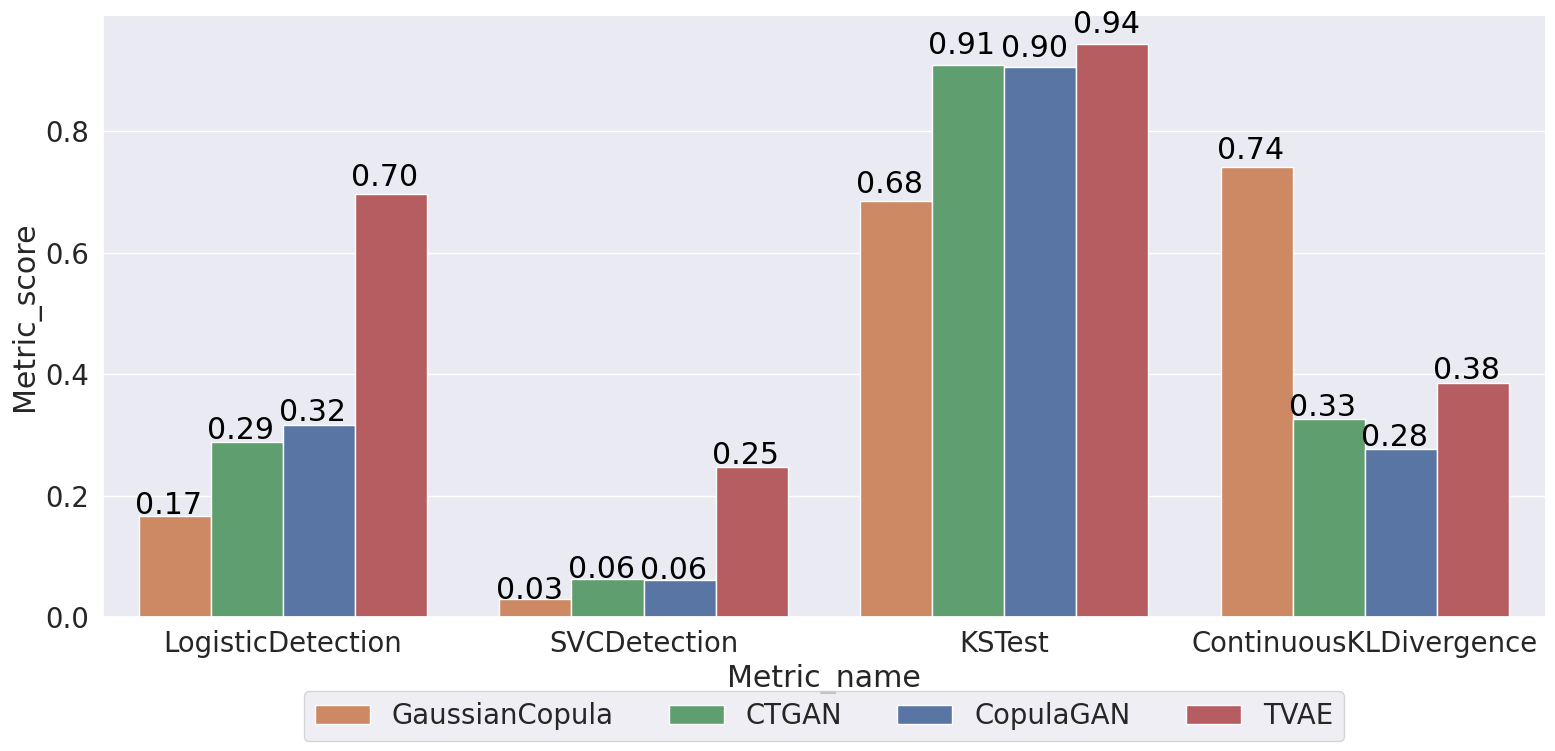

In [67]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_enc, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_enc)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

In [35]:
va = VectorAssembler(
    inputCols=enc_users_train.columns[:-1] + ITEMS_FEATURES,
    outputCol='features'
)

train_df = log_df_val\
    .join(enc_users_train, 'user_idx', 'left')\
    .join(items_df_train, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .join(enc_users_val, 'user_idx', 'left')\
    .join(items_df_val, 'item_idx', 'left')\
    .drop('timestamp')\
    .na.drop()\
    .cache()

In [36]:
enc_feature_metrics = []

# Logistic Regression

In [37]:
enc_feature_metrics.append(
    test_model(
        model_class=LogisticRegression,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with LogisticRegression: 195.40476250648499


Regression ROC AUC: 0.671904108082391


# Random forest

In [38]:
enc_feature_metrics.append(
    test_model(
        model_class=RandomForestClassifier,
        train_data=train_df,
        test_data=test_df,
        assembler=va,
        extractor=vee,
        bernoulli=br
    )
)

Fitting of pipeline with RandomForestClassifier: 90.69589591026306


Regression ROC AUC: 0.6056441562548962


In [40]:
train_df.unpersist()
test_df.unpersist()

enc_users_train.unpersist()
enc_users_val.unpersist()

pd.DataFrame(enc_feature_metrics)

,Model,ROC-AUC
0,LogisticRegression,0.671904
1,RandomForestClassifier,0.605644


Качество моделей генерации синтетики в случае эмбеддингов на основе автоэнкодера хуже чем в случае PCA. Качество компоненты Real на эмбеддингах сопоставимо с качеством компоненты Real на исходных профилях для всех моделей отклика.

По результатам экспериментального исследования было принято решение об использовании метода главных компонент для датасета Netflix (в сочетании с моделью генерации TVAE).